In [13]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


In [14]:
# Load dataset
# Here, We load the dataset and confirm it contains stock price columns like Date, Open, High, Low, Close, Volume, Adj Close.
df = pd.read_csv("Tesla.csv")

# Display first few rows
df.head()


,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [15]:
# Select 'Open' column
data = df[['Open']].values  

# Scale between 0 and 1 for stable training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [16]:
# Here, We frame the problem as a supervised learning task where sequences of 60 timesteps map to the next day’s opening price.
def create_sequences(dataset, time_steps=60):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps, 0])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Reshape to RNN input format: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [18]:
# LSTM-based Model
# Two stacked LSTM layers help capture temporal dependencies; Dropout reduces overfitting.
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training the model
# The model is trained for 50 epochs with Adam optimizer.
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0314 - val_loss: 0.0030
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

In [20]:
# Make predictions
# RMSE and MAE tell us how close the predictions are to actual prices.
y_pred = model.predict(X_test)

# Inverse scaling back to real prices
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Root Mean Squared Error (RMSE): 8.7559947556106
Mean Absolute Error (MAE): 6.732832599230097


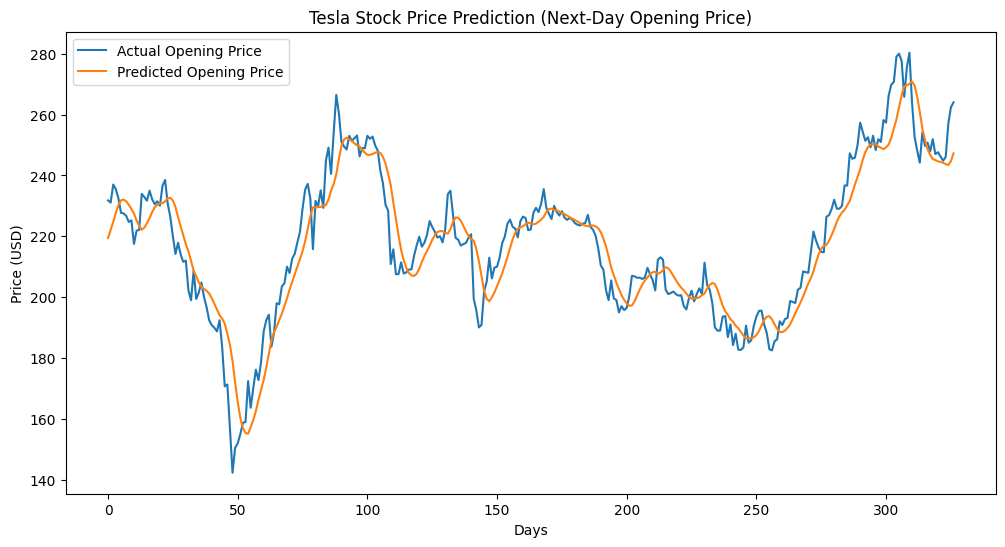

In [22]:
# Visual Representation
# The plot helps us visually inspect how well predictions follow the actual stock prices.
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Opening Price")
plt.plot(y_pred_rescaled, label="Predicted Opening Price")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Tesla Stock Price Prediction (Next-Day Opening Price)")
plt.legend()
plt.show()

